In [1]:
# Cell 1: Installer les dépendances
!pip install optuna keras-tuner keras-tcn tensorflow-addons


In [2]:
# Cell 2: Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import (
    LSTM, Bidirectional, Conv1D, MaxPooling1D, Flatten,
    GRU, SimpleRNN, Dense, Dropout,
    MultiHeadAttention, Add, LayerNormalization
)
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from optuna.pruners import MedianPruner
import keras_tuner as kt
from tcn import TCN
import matplotlib.pyplot as plt


In [3]:
# Cell 3: Chargement et nettoyage des données
file_path = r"C:/Users/Mouhcine/Desktop/M_eco-main/M_eco-main/Dataset/Dataset_Timeseries.csv"
df = pd.read_csv(file_path)
# date → index
df.rename(columns={df.columns[0]:'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
# nettoyage numérique
num_cols = df.columns
df[num_cols] = df[num_cols].replace({' ': '', '\xa0': ''}, regex=True).astype(float)
df.ffill(inplace=True); df.bfill(inplace=True)


In [4]:
# Cell 4: Feature engineering basique
df['month_sin'] = np.sin(2*np.pi*df.index.month/12)
df['month_cos'] = np.cos(2*np.pi*df.index.month/12)
df['dow_sin']   = np.sin(2*np.pi*df.index.dayofweek/7)
df['dow_cos']   = np.cos(2*np.pi*df.index.dayofweek/7)


In [5]:
# Cell 5: Split chronologique train / val / test
n = len(df)
train_end = int(n*0.7)
val_end   = int(n*0.85)
train_df = df.iloc[:train_end]
val_df   = df.iloc[train_end:val_end]
test_df  = df.iloc[val_end:]


In [6]:
# Cell 6: Scaling (fit sur train uniquement)
scaler = MinMaxScaler().fit(train_df)


In [7]:
# Cell 7: Création des séquences temporelles
def make_sequences(df_):
    arr = scaler.transform(df_)
    X, y = [], []
    SEQ = 30
    for i in range(len(arr)-SEQ):
        X.append(arr[i:i+SEQ])
        y.append(arr[i+SEQ,:len(num_cols)])
    return np.array(X), np.array(y)

X_train, y_train = make_sequences(train_df)
X_val,   y_val   = make_sequences(pd.concat([train_df.iloc[-30:], val_df]))
X_test,  y_test  = make_sequences(pd.concat([val_df.iloc[-30:], test_df]))
n_features = X_train.shape[2]


In [8]:
# Cell 8: Walk-Forward CV utilitaire
def walk_forward_cv(X, y, n_splits=3):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for tr, te in tscv.split(X):
        yield X[tr], y[tr], X[te], y[te]


In [9]:
# Cell 9: Définition des build_functions pour les 7 modèles
def build_lstm(trial):
    u   = trial.suggest_int("units", 32,256)
    d   = trial.suggest_float("dropout",0,0.5)
    L   = trial.suggest_int("n_layers",1,3)
    m   = Sequential([Input((30,n_features))])
    for i in range(L):
        rs = i< L-1
        m.add(LSTM(u,return_sequences=rs))
        m.add(Dropout(d))
    m.add(Dense(len(num_cols)))
    m.compile("adam","mse"); return m

def build_bilstm(trial):
    u   = trial.suggest_int("units",32,256)
    d   = trial.suggest_float("dropout",0,0.5)
    L   = trial.suggest_int("n_layers",1,3)
    m   = Sequential([Input((30,n_features))])
    for i in range(L):
        rs = i< L-1
        m.add(Bidirectional(LSTM(u,return_sequences=rs)))
        m.add(Dropout(d))
    m.add(Dense(len(num_cols)))
    m.compile("adam","mse"); return m

def build_lstm_cnn(trial):
    lu  = trial.suggest_int("lstm_units",32,256)
    cf  = trial.suggest_int("cnn_filters",16,128)
    ks  = trial.suggest_int("kernel_size",2,5)
    d   = trial.suggest_float("dropout",0,0.5)
    inp=Input((30,n_features))
    x = LSTM(lu,return_sequences=True)(inp)
    x = Conv1D(cf,ks,activation="relu")(x)
    x = MaxPooling1D()(x)
    x = Flatten()(x); x = Dropout(d)(x)
    out= Dense(len(num_cols))(x)
    m=Model(inp,out); m.compile("adam","mse"); return m

def build_gru(trial):
    u=trial.suggest_int("units",32,256)
    d=trial.suggest_float("dropout",0,0.5)
    L=trial.suggest_int("n_layers",1,3)
    m=Sequential([Input((30,n_features))])
    for i in range(L):
        rs=i< L-1
        m.add(GRU(u,return_sequences=rs))
        m.add(Dropout(d))
    m.add(Dense(len(num_cols))); m.compile("adam","mse"); return m

def build_rnn(trial):
    u=trial.suggest_int("units",32,256)
    d=trial.suggest_float("dropout",0,0.5)
    L=trial.suggest_int("n_layers",1,3)
    m=Sequential([Input((30,n_features))])
    for i in range(L):
        rs=i< L-1
        m.add(SimpleRNN(u,return_sequences=rs))
        m.add(Dropout(d))
    m.add(Dense(len(num_cols))); m.compile("adam","mse"); return m

def build_tcn(trial):
    f=trial.suggest_int("filters",16,128)
    ks=trial.suggest_int("kernel_size",2,5)
    d=trial.suggest_float("dropout",0,0.5)
    inp=Input((30,n_features))
    x = TCN(nb_filters=f,kernel_size=ks,dilations=[1,2,4],dropout_rate=d)(inp)
    out= Dense(len(num_cols))(x)
    m=Model(inp,out); m.compile("adam","mse"); return m

# Cell 9 (modifiée) : Définition des build_functions pour les 7 modèles,
# avec build_transformer corrigé

def build_transformer(trial):
    d_model   = trial.suggest_int("d_model", 32, 128)
    num_heads = trial.suggest_int("num_heads", 1, 4)
    ff_dim    = trial.suggest_int("ff_dim", 32, 128)
    dropout   = trial.suggest_float("dropout", 0.0, 0.5)

    inp = Input(shape=(30, n_features))
    # 1) Self-attention
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inp, inp)
    attn = Dropout(dropout)(attn)

    # 2) Residual + Norm (attention)
    x1 = Add()([inp, attn])
    x1 = LayerNormalization(epsilon=1e-6)(x1)

    # 3) Feed-forward on last dim d_model
    ffn = Dense(ff_dim, activation="relu")(x1)
    ffn = Dropout(dropout)(ffn)
    ffn = Dense(d_model)(ffn)  # <-- on ramène à d_model, pas à len(num_cols)

    # 4) Residual + Norm (FFN)
    x2 = Add()([x1, ffn])
    x2 = LayerNormalization(epsilon=1e-6)(x2)

    # 5) Flatten & projection finale vers len(num_cols)
    flat = Flatten()(x2)
    out  = Dense(len(num_cols), activation="linear")(flat)

    model = Model(inp, out)
    model.compile(optimizer="adam", loss="mse")
    return model



In [10]:
# Cell 10a: Coarse tuning Optuna pour LSTM
import os
import pickle
from sklearn.metrics import mean_squared_error

def objective_lstm(trial):
    cv_scores = []
    for Xt, yt, Xv, yv in walk_forward_cv(X_train, y_train):
        m = build_lstm(trial)
        m.fit(Xt, yt,
              validation_data=(Xv, yv),
              epochs=30, batch_size=32,
              callbacks=[EarlyStopping('val_loss', 5, restore_best_weights=True)],
              verbose=0)
        preds = m.predict(Xv)
        score = mean_squared_error(yv, preds)
        trial.report(score, len(cv_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_lstm = optuna.create_study(direction='minimize', pruner=MedianPruner())
study_lstm.optimize(objective_lstm, n_trials=20)
best_params_lstm = study_lstm.best_trial.params
print("Best LSTM params:", best_params_lstm)



# Créer le dossier s'il n'existe pas
os.makedirs('optuna_studies', exist_ok=True)

# Sauvegarder l'étude Optuna
with open('optuna_studies/study_lstm.pkl', 'wb') as f:
    pickle.dump(study_lstm, f)
print("LSTM study saved to: optuna_studies/study_lstm.pkl")

# Entraîner et sauvegarder le meilleur modèle LSTM
best_trial = optuna.trial.FixedTrial(best_params_lstm)
best_lstm_model = build_lstm(best_trial)
best_lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
best_lstm_model.save('optuna_studies/best_lstm_model.h5')
print("Best LSTM model saved to: optuna_studies/best_lstm_model.h5")


[I 2025-05-30 23:43:27,535] A new study created in memory with name: no-name-da46e5c1-f718-4b1d-b15f-34a38e1968a0


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000270BE359A80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


[I 2025-05-30 23:43:51,691] Trial 0 finished with value: 0.040936472736203475 and parameters: {'units': 78, 'dropout': 0.05264878324479966, 'n_layers': 1}. Best is trial 0 with value: 0.040936472736203475.


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 470ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step


[I 2025-05-30 23:44:23,857] Trial 1 finished with value: 0.036172593472276526 and parameters: {'units': 186, 'dropout': 0.400457369385214, 'n_layers': 1}. Best is trial 1 with value: 0.036172593472276526.


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 837ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step


[I 2025-05-30 23:45:06,642] Trial 2 finished with value: 0.034453237291209936 and parameters: {'units': 229, 'dropout': 0.4583046702487661, 'n_layers': 3}. Best is trial 2 with value: 0.034453237291209936.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step


[I 2025-05-30 23:45:29,559] Trial 3 finished with value: 0.03450171985117188 and parameters: {'units': 225, 'dropout': 0.26124253552913684, 'n_layers': 3}. Best is trial 2 with value: 0.034453237291209936.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


[I 2025-05-30 23:45:38,071] Trial 4 finished with value: 0.03683443857407845 and parameters: {'units': 112, 'dropout': 0.024347616804384797, 'n_layers': 1}. Best is trial 2 with value: 0.034453237291209936.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step


[I 2025-05-30 23:45:59,534] Trial 5 finished with value: 0.0349081161190093 and parameters: {'units': 131, 'dropout': 0.13562161605782325, 'n_layers': 3}. Best is trial 2 with value: 0.034453237291209936.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


[I 2025-05-30 23:46:15,355] Trial 6 finished with value: 0.03383473098783515 and parameters: {'units': 196, 'dropout': 0.46112496059583225, 'n_layers': 2}. Best is trial 6 with value: 0.03383473098783515.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


[I 2025-05-30 23:46:20,809] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step


[I 2025-05-30 23:46:25,334] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


[I 2025-05-30 23:46:30,676] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


[I 2025-05-30 23:46:45,836] Trial 10 finished with value: 0.0344479062286785 and parameters: {'units': 174, 'dropout': 0.33166384017798856, 'n_layers': 2}. Best is trial 6 with value: 0.03383473098783515.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


[I 2025-05-30 23:47:01,175] Trial 11 finished with value: 0.03445156011396109 and parameters: {'units': 174, 'dropout': 0.33731859939736086, 'n_layers': 2}. Best is trial 6 with value: 0.03383473098783515.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


[I 2025-05-30 23:47:16,968] Trial 12 finished with value: 0.03456792508621392 and parameters: {'units': 175, 'dropout': 0.3418452104413887, 'n_layers': 2}. Best is trial 6 with value: 0.03383473098783515.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


[I 2025-05-30 23:47:33,247] Trial 13 finished with value: 0.034567323053898084 and parameters: {'units': 253, 'dropout': 0.4612109289612345, 'n_layers': 2}. Best is trial 6 with value: 0.03383473098783515.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step


[I 2025-05-30 23:47:39,538] Trial 14 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


[I 2025-05-30 23:47:42,247] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


[I 2025-05-30 23:47:58,353] Trial 16 finished with value: 0.03432924340102745 and parameters: {'units': 203, 'dropout': 0.38437070034241977, 'n_layers': 2}. Best is trial 6 with value: 0.03383473098783515.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step


[I 2025-05-30 23:48:21,203] Trial 17 finished with value: 0.03490513799111547 and parameters: {'units': 212, 'dropout': 0.4047836444198508, 'n_layers': 3}. Best is trial 6 with value: 0.03383473098783515.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


[I 2025-05-30 23:48:24,028] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


[I 2025-05-30 23:48:40,706] Trial 19 finished with value: 0.03284843973154803 and parameters: {'units': 252, 'dropout': 0.4370547836557974, 'n_layers': 2}. Best is trial 19 with value: 0.03284843973154803.


Best LSTM params: {'units': 252, 'dropout': 0.4370547836557974, 'n_layers': 2}
LSTM study saved to: optuna_studies/study_lstm.pkl


Best LSTM model saved to: optuna_studies/best_lstm_model.h5


In [11]:
# Cell 10b: Coarse tuning Optuna pour BiLSTM

def objective_bilstm(trial):
    cv_scores = []
    for Xt, yt, Xv, yv in walk_forward_cv(X_train, y_train):
        m = build_bilstm(trial)
        m.fit(Xt, yt,
              validation_data=(Xv, yv),
              epochs=30, batch_size=32,
              callbacks=[EarlyStopping('val_loss', 5, restore_best_weights=True)],
              verbose=0)
        preds = m.predict(Xv)
        score = mean_squared_error(yv, preds)
        trial.report(score, len(cv_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_bilstm = optuna.create_study(direction='minimize', pruner=MedianPruner())
study_bilstm.optimize(objective_bilstm, n_trials=20)
best_params_bilstm = study_bilstm.best_trial.params
print("Best BiLSTM params:", best_params_bilstm)

# Sauvegarder l'étude Optuna
with open('optuna_studies/study_bilstm.pkl', 'wb') as f:
    pickle.dump(study_bilstm, f)
print("BiLSTM study saved to: optuna_studies/study_bilstm.pkl")

# Entraîner et sauvegarder le meilleur modèle BiLSTM
best_trial = optuna.trial.FixedTrial(best_params_bilstm)
best_bilstm_model = build_bilstm(best_trial)
best_bilstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
best_bilstm_model.save('optuna_studies/best_bilstm_model.h5')
print("Best BiLSTM model saved to: optuna_studies/best_bilstm_model.h5")


[I 2025-05-30 23:49:14,899] A new study created in memory with name: no-name-1c0f09d0-3794-4ed4-bb71-1cc16af9ce67


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step


[I 2025-05-30 23:49:53,859] Trial 0 finished with value: 0.03525480467270784 and parameters: {'units': 93, 'dropout': 0.01613311168869458, 'n_layers': 3}. Best is trial 0 with value: 0.03525480467270784.


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 487ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 471ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 478ms/step


[I 2025-05-30 23:50:36,478] Trial 1 finished with value: 0.03298182549481623 and parameters: {'units': 194, 'dropout': 0.16663498985905878, 'n_layers': 3}. Best is trial 1 with value: 0.03298182549481623.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step


[I 2025-05-30 23:51:06,860] Trial 2 finished with value: 0.03251238727986431 and parameters: {'units': 225, 'dropout': 0.13948346564564662, 'n_layers': 2}. Best is trial 2 with value: 0.03251238727986431.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


[I 2025-05-30 23:51:23,426] Trial 3 finished with value: 0.034636878484703704 and parameters: {'units': 159, 'dropout': 0.30190351795676823, 'n_layers': 1}. Best is trial 2 with value: 0.03251238727986431.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


[I 2025-05-30 23:51:36,768] Trial 4 finished with value: 0.035066018279067655 and parameters: {'units': 118, 'dropout': 0.03276221449066391, 'n_layers': 1}. Best is trial 2 with value: 0.03251238727986431.


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


[I 2025-05-30 23:51:52,758] Trial 5 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step


[I 2025-05-30 23:52:31,598] Trial 6 finished with value: 0.03642330372821476 and parameters: {'units': 50, 'dropout': 0.4824757396412957, 'n_layers': 3}. Best is trial 2 with value: 0.03251238727986431.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


[I 2025-05-30 23:52:36,043] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step


[I 2025-05-30 23:52:40,445] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


[I 2025-05-30 23:52:53,687] Trial 9 finished with value: 0.032664528051096035 and parameters: {'units': 98, 'dropout': 0.11317382269701115, 'n_layers': 1}. Best is trial 2 with value: 0.03251238727986431.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step


[I 2025-05-30 23:53:15,420] Trial 10 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step


[I 2025-05-30 23:53:23,852] Trial 11 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step


[I 2025-05-30 23:53:55,085] Trial 12 finished with value: 0.03345315857762054 and parameters: {'units': 209, 'dropout': 0.2265310149295092, 'n_layers': 2}. Best is trial 2 with value: 0.03251238727986431.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


[I 2025-05-30 23:54:03,271] Trial 13 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


[I 2025-05-30 23:54:07,610] Trial 14 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step


[I 2025-05-30 23:54:16,023] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step


[I 2025-05-30 23:54:20,470] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step


[I 2025-05-30 23:54:49,618] Trial 17 finished with value: 0.036334473525649245 and parameters: {'units': 154, 'dropout': 0.27509658058996106, 'n_layers': 2}. Best is trial 2 with value: 0.03251238727986431.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step


[I 2025-05-30 23:54:58,114] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step


[I 2025-05-30 23:55:11,882] Trial 19 finished with value: 0.03587446766292583 and parameters: {'units': 102, 'dropout': 0.19684025928982876, 'n_layers': 1}. Best is trial 2 with value: 0.03251238727986431.


Best BiLSTM params: {'units': 225, 'dropout': 0.13948346564564662, 'n_layers': 2}
BiLSTM study saved to: optuna_studies/study_bilstm.pkl


Best BiLSTM model saved to: optuna_studies/best_bilstm_model.h5


In [12]:
# Cell 10c: Coarse tuning Optuna pour LSTM-CNN

def objective_lstm_cnn(trial):
    cv_scores = []
    for Xt, yt, Xv, yv in walk_forward_cv(X_train, y_train):
        m = build_lstm_cnn(trial)
        m.fit(Xt, yt,
              validation_data=(Xv, yv),
              epochs=30, batch_size=32,
              callbacks=[EarlyStopping('val_loss', 5, restore_best_weights=True)],
              verbose=0)
        preds = m.predict(Xv)
        score = mean_squared_error(yv, preds)
        trial.report(score, len(cv_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_lstm_cnn = optuna.create_study(direction='minimize', pruner=MedianPruner())
study_lstm_cnn.optimize(objective_lstm_cnn, n_trials=20)
best_params_lstm_cnn = study_lstm_cnn.best_trial.params
print("Best LSTM-CNN params:", best_params_lstm_cnn)

# Sauvegarder l'étude Optuna
with open('optuna_studies/study_lstm_cnn.pkl', 'wb') as f:
    pickle.dump(study_lstm_cnn, f)
print("LSTM-CNN study saved to: optuna_studies/study_lstm_cnn.pkl")

# Entraîner et sauvegarder le meilleur modèle LSTM-CNN
best_trial = optuna.trial.FixedTrial(best_params_lstm_cnn)
best_lstm_cnn_model = build_lstm_cnn(best_trial)
best_lstm_cnn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
best_lstm_cnn_model.save('optuna_studies/best_lstm_cnn_model.h5')
print("Best LSTM-CNN model saved to: optuna_studies/best_lstm_cnn_model.h5")


[I 2025-05-30 23:56:32,173] A new study created in memory with name: no-name-54cc65cb-a8c0-45e5-b2ea-eb8aa49a2548


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


[I 2025-05-30 23:56:49,205] Trial 0 finished with value: 0.033450215231455915 and parameters: {'lstm_units': 177, 'cnn_filters': 59, 'kernel_size': 3, 'dropout': 0.11751912562685568}. Best is trial 0 with value: 0.033450215231455915.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


[I 2025-05-30 23:56:59,309] Trial 1 finished with value: 0.0336857400957459 and parameters: {'lstm_units': 121, 'cnn_filters': 80, 'kernel_size': 2, 'dropout': 0.01742674939456207}. Best is trial 0 with value: 0.033450215231455915.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


[I 2025-05-30 23:57:09,310] Trial 2 finished with value: 0.0336136452243657 and parameters: {'lstm_units': 151, 'cnn_filters': 103, 'kernel_size': 4, 'dropout': 0.21315248275129428}. Best is trial 0 with value: 0.033450215231455915.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


[I 2025-05-30 23:57:19,533] Trial 3 finished with value: 0.03686123756654825 and parameters: {'lstm_units': 76, 'cnn_filters': 30, 'kernel_size': 4, 'dropout': 0.20243868250801195}. Best is trial 0 with value: 0.033450215231455915.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


[I 2025-05-30 23:57:29,654] Trial 4 finished with value: 0.03598335114249201 and parameters: {'lstm_units': 132, 'cnn_filters': 93, 'kernel_size': 2, 'dropout': 0.0018846933579117486}. Best is trial 0 with value: 0.033450215231455915.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


[I 2025-05-30 23:57:39,670] Trial 5 finished with value: 0.035263996079363556 and parameters: {'lstm_units': 207, 'cnn_filters': 81, 'kernel_size': 2, 'dropout': 0.4611093342673611}. Best is trial 0 with value: 0.033450215231455915.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


[I 2025-05-30 23:57:54,035] Trial 6 finished with value: 0.035246131339790175 and parameters: {'lstm_units': 169, 'cnn_filters': 55, 'kernel_size': 4, 'dropout': 0.15479367544709188}. Best is trial 0 with value: 0.033450215231455915.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


[I 2025-05-30 23:57:57,535] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


[I 2025-05-30 23:58:00,877] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


[I 2025-05-30 23:58:04,352] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


[I 2025-05-30 23:58:07,783] Trial 10 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


[I 2025-05-30 23:58:17,670] Trial 11 finished with value: 0.034076838212963284 and parameters: {'lstm_units': 83, 'cnn_filters': 124, 'kernel_size': 5, 'dropout': 0.11974512057269818}. Best is trial 0 with value: 0.033450215231455915.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


[I 2025-05-30 23:58:22,054] Trial 12 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


[I 2025-05-30 23:58:32,095] Trial 13 finished with value: 0.0336199402769771 and parameters: {'lstm_units': 178, 'cnn_filters': 59, 'kernel_size': 3, 'dropout': 0.17908437533994484}. Best is trial 0 with value: 0.033450215231455915.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


[I 2025-05-30 23:58:42,296] Trial 14 finished with value: 0.0341132932486457 and parameters: {'lstm_units': 209, 'cnn_filters': 103, 'kernel_size': 4, 'dropout': 0.07675367465950816}. Best is trial 0 with value: 0.033450215231455915.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


[I 2025-05-30 23:58:45,527] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


[I 2025-05-30 23:58:59,508] Trial 16 finished with value: 0.03346462809249959 and parameters: {'lstm_units': 156, 'cnn_filters': 69, 'kernel_size': 5, 'dropout': 0.2597045611653872}. Best is trial 0 with value: 0.033450215231455915.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


[I 2025-05-30 23:59:02,922] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


[I 2025-05-30 23:59:06,476] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


[I 2025-05-30 23:59:16,406] Trial 19 finished with value: 0.035026109127830385 and parameters: {'lstm_units': 150, 'cnn_filters': 64, 'kernel_size': 3, 'dropout': 0.3761497122981577}. Best is trial 0 with value: 0.033450215231455915.


Best LSTM-CNN params: {'lstm_units': 177, 'cnn_filters': 59, 'kernel_size': 3, 'dropout': 0.11751912562685568}
LSTM-CNN study saved to: optuna_studies/study_lstm_cnn.pkl


Best LSTM-CNN model saved to: optuna_studies/best_lstm_cnn_model.h5


In [13]:
# Cell 10d: Coarse tuning Optuna pour GRU

def objective_gru(trial):
    cv_scores = []
    for Xt, yt, Xv, yv in walk_forward_cv(X_train, y_train):
        m = build_gru(trial)
        m.fit(Xt, yt,
              validation_data=(Xv, yv),
              epochs=30, batch_size=32,
              callbacks=[EarlyStopping('val_loss', 5, restore_best_weights=True)],
              verbose=0)
        preds = m.predict(Xv)
        score = mean_squared_error(yv, preds)
        trial.report(score, len(cv_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_gru = optuna.create_study(direction='minimize', pruner=MedianPruner())
study_gru.optimize(objective_gru, n_trials=20)
best_params_gru = study_gru.best_trial.params
print("Best GRU params:", best_params_gru)


# Sauvegarder l'étude Optuna
with open('optuna_studies/study_gru.pkl', 'wb') as f:
    pickle.dump(study_gru, f)
print("GRU study saved to: optuna_studies/study_gru.pkl")

# Entraîner et sauvegarder le meilleur modèle GRU
best_trial = optuna.trial.FixedTrial(best_params_gru)
best_gru_model = build_gru(best_trial)
best_gru_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
best_gru_model.save('optuna_studies/best_gru_model.h5')
print("Best GRU model saved to: optuna_studies/best_gru_model.h5")


[I 2025-05-30 23:59:31,417] A new study created in memory with name: no-name-00170ec9-59e2-45e1-a4f2-ff6968238c01


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


[I 2025-05-30 23:59:57,824] Trial 0 finished with value: 0.03357166457489467 and parameters: {'units': 206, 'dropout': 0.2750272856665133, 'n_layers': 3}. Best is trial 0 with value: 0.03357166457489467.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 451ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2025-05-31 00:00:28,588] Trial 1 finished with value: 0.03241088921593088 and parameters: {'units': 176, 'dropout': 0.17572118080432642, 'n_layers': 3}. Best is trial 1 with value: 0.03241088921593088.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


[I 2025-05-31 00:00:46,560] Trial 2 finished with value: 0.031892397698735586 and parameters: {'units': 252, 'dropout': 0.24392566423944367, 'n_layers': 2}. Best is trial 2 with value: 0.031892397698735586.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


[I 2025-05-31 00:00:57,043] Trial 3 finished with value: 0.04210828167427355 and parameters: {'units': 155, 'dropout': 0.2026464635322977, 'n_layers': 1}. Best is trial 2 with value: 0.031892397698735586.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step


[I 2025-05-31 00:01:14,922] Trial 4 finished with value: 0.03263779641983858 and parameters: {'units': 227, 'dropout': 0.10014295841519127, 'n_layers': 2}. Best is trial 2 with value: 0.031892397698735586.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


[I 2025-05-31 00:01:21,762] Trial 5 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


[I 2025-05-31 00:01:24,984] Trial 6 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-05-31 00:01:37,470] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


[I 2025-05-31 00:01:45,466] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step


[I 2025-05-31 00:01:56,975] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


[I 2025-05-31 00:02:00,376] Trial 10 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step


[I 2025-05-31 00:02:18,918] Trial 11 finished with value: 0.03191825691366043 and parameters: {'units': 189, 'dropout': 0.15273019375181388, 'n_layers': 2}. Best is trial 2 with value: 0.031892397698735586.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step


[I 2025-05-31 00:02:24,488] Trial 12 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step


[I 2025-05-31 00:02:29,934] Trial 13 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


[I 2025-05-31 00:02:35,362] Trial 14 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


[I 2025-05-31 00:02:38,601] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


[I 2025-05-31 00:02:44,447] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


[I 2025-05-31 00:02:53,173] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step


[I 2025-05-31 00:02:58,899] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-05-31 00:03:07,144] Trial 19 pruned. 


Best GRU params: {'units': 252, 'dropout': 0.24392566423944367, 'n_layers': 2}
GRU study saved to: optuna_studies/study_gru.pkl


Best GRU model saved to: optuna_studies/best_gru_model.h5


In [14]:
# Cell 10e: Coarse tuning Optuna pour RNN

def objective_rnn(trial):
    cv_scores = []
    for Xt, yt, Xv, yv in walk_forward_cv(X_train, y_train):
        m = build_rnn(trial)
        m.fit(Xt, yt,
              validation_data=(Xv, yv),
              epochs=30, batch_size=32,
              callbacks=[EarlyStopping('val_loss', 5, restore_best_weights=True)],
              verbose=0)
        preds = m.predict(Xv)
        score = mean_squared_error(yv, preds)
        trial.report(score, len(cv_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_rnn = optuna.create_study(direction='minimize', pruner=MedianPruner())
study_rnn.optimize(objective_rnn, n_trials=20)
best_params_rnn = study_rnn.best_trial.params
print("Best RNN params:", best_params_rnn)


# Sauvegarder l'étude Optuna
with open('optuna_studies/study_rnn.pkl', 'wb') as f:
    pickle.dump(study_rnn, f)
print("RNN study saved to: optuna_studies/study_rnn.pkl")

# Entraîner et sauvegarder le meilleur modèle RNN
best_trial = optuna.trial.FixedTrial(best_params_rnn)
best_rnn_model = build_rnn(best_trial)
best_rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
best_rnn_model.save('optuna_studies/best_rnn_model.h5')
print("Best RNN model saved to: optuna_studies/best_rnn_model.h5")


[I 2025-05-31 00:03:43,784] A new study created in memory with name: no-name-6ff07082-2977-4d18-ae46-2d8b566b78ab


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


[I 2025-05-31 00:04:00,182] Trial 0 finished with value: 0.28563598296405074 and parameters: {'units': 46, 'dropout': 0.3164486761687229, 'n_layers': 3}. Best is trial 0 with value: 0.28563598296405074.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


[I 2025-05-31 00:04:07,478] Trial 1 finished with value: 0.07774358275962039 and parameters: {'units': 189, 'dropout': 0.20446487240255112, 'n_layers': 1}. Best is trial 1 with value: 0.07774358275962039.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


[I 2025-05-31 00:04:14,647] Trial 2 finished with value: 0.1072319592548695 and parameters: {'units': 119, 'dropout': 0.3380079953543342, 'n_layers': 1}. Best is trial 1 with value: 0.07774358275962039.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step


[I 2025-05-31 00:04:22,243] Trial 3 finished with value: 0.07549791946470712 and parameters: {'units': 199, 'dropout': 0.24455436700112765, 'n_layers': 1}. Best is trial 3 with value: 0.07549791946470712.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


[I 2025-05-31 00:04:34,876] Trial 4 finished with value: 0.1973040054674052 and parameters: {'units': 147, 'dropout': 0.4629975933828718, 'n_layers': 2}. Best is trial 3 with value: 0.07549791946470712.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


[I 2025-05-31 00:04:46,434] Trial 5 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


[I 2025-05-31 00:04:50,232] Trial 6 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


[I 2025-05-31 00:04:54,130] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


[I 2025-05-31 00:05:01,585] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


[I 2025-05-31 00:05:05,452] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


[I 2025-05-31 00:05:15,286] Trial 10 finished with value: 0.08027382361578785 and parameters: {'units': 242, 'dropout': 0.18147218670998583, 'n_layers': 1}. Best is trial 3 with value: 0.07549791946470712.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


[I 2025-05-31 00:05:22,961] Trial 11 finished with value: 0.08221560283740063 and parameters: {'units': 184, 'dropout': 0.18949281550810282, 'n_layers': 1}. Best is trial 3 with value: 0.07549791946470712.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2025-05-31 00:05:30,661] Trial 12 finished with value: 0.07908386930308064 and parameters: {'units': 177, 'dropout': 0.22824729984784137, 'n_layers': 1}. Best is trial 3 with value: 0.07549791946470712.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


[I 2025-05-31 00:05:38,058] Trial 13 finished with value: 0.06524200482972277 and parameters: {'units': 233, 'dropout': 0.107340356529642, 'n_layers': 1}. Best is trial 13 with value: 0.06524200482972277.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


[I 2025-05-31 00:05:45,806] Trial 14 finished with value: 0.06398404893691095 and parameters: {'units': 247, 'dropout': 0.11446750636291379, 'n_layers': 1}. Best is trial 14 with value: 0.06398404893691095.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


[I 2025-05-31 00:05:53,240] Trial 15 finished with value: 0.06913956313973783 and parameters: {'units': 249, 'dropout': 0.11454195638165986, 'n_layers': 1}. Best is trial 14 with value: 0.06398404893691095.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


[I 2025-05-31 00:05:57,246] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-31 00:05:59,881] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


[I 2025-05-31 00:06:02,261] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


[I 2025-05-31 00:06:06,255] Trial 19 pruned. 


Best RNN params: {'units': 247, 'dropout': 0.11446750636291379, 'n_layers': 1}
RNN study saved to: optuna_studies/study_rnn.pkl


Best RNN model saved to: optuna_studies/best_rnn_model.h5


In [15]:
# Cell 10f: Coarse tuning Optuna pour TCN

def objective_tcn(trial):
    cv_scores = []
    for Xt, yt, Xv, yv in walk_forward_cv(X_train, y_train):
        m = build_tcn(trial)
        m.fit(Xt, yt,
              validation_data=(Xv, yv),
              epochs=30, batch_size=32,
              callbacks=[EarlyStopping('val_loss', 5, restore_best_weights=True)],
              verbose=0)
        preds = m.predict(Xv)
        score = mean_squared_error(yv, preds)
        trial.report(score, len(cv_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_tcn = optuna.create_study(direction='minimize', pruner=MedianPruner())
study_tcn.optimize(objective_tcn, n_trials=20)
best_params_tcn = study_tcn.best_trial.params
print("Best TCN params:", best_params_tcn)


# Sauvegarder l'étude Optuna
with open('optuna_studies/study_tcn.pkl', 'wb') as f:
    pickle.dump(study_tcn, f)
print("TCN study saved to: optuna_studies/study_tcn.pkl")

# Entraîner et sauvegarder le meilleur modèle TCN
best_trial = optuna.trial.FixedTrial(best_params_tcn)
best_tcn_model = build_tcn(best_trial)
best_tcn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
best_tcn_model.save_weights('optuna_studies/best_tcn_weights.weights.h5')
print("Best TCN model saved to: optuna_studies/best_tcn_model.h5")


[I 2025-05-31 00:06:14,709] A new study created in memory with name: no-name-866edef2-47cd-4d2a-9d26-15623f55373b


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 7s/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


[I 2025-05-31 00:06:48,933] Trial 0 finished with value: 0.37184707762334707 and parameters: {'filters': 62, 'kernel_size': 2, 'dropout': 0.33856613142492586}. Best is trial 0 with value: 0.37184707762334707.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


[I 2025-05-31 00:07:04,507] Trial 1 finished with value: 0.18184805022129816 and parameters: {'filters': 95, 'kernel_size': 5, 'dropout': 0.1669976145577714}. Best is trial 1 with value: 0.18184805022129816.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


[I 2025-05-31 00:07:20,883] Trial 2 finished with value: 0.14212801183184862 and parameters: {'filters': 119, 'kernel_size': 4, 'dropout': 0.14857624754411802}. Best is trial 2 with value: 0.14212801183184862.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


[I 2025-05-31 00:07:36,744] Trial 3 finished with value: 0.15771973379523854 and parameters: {'filters': 104, 'kernel_size': 5, 'dropout': 0.0002070112546880276}. Best is trial 2 with value: 0.14212801183184862.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


[I 2025-05-31 00:07:52,054] Trial 4 finished with value: 0.2092800392799247 and parameters: {'filters': 40, 'kernel_size': 5, 'dropout': 0.05432134676912853}. Best is trial 2 with value: 0.14212801183184862.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


[I 2025-05-31 00:07:57,497] Trial 5 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


[I 2025-05-31 00:08:02,938] Trial 6 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


[I 2025-05-31 00:08:31,314] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


[I 2025-05-31 00:08:36,669] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


[I 2025-05-31 00:08:42,277] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


[I 2025-05-31 00:08:47,434] Trial 10 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


[I 2025-05-31 00:08:52,617] Trial 11 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


[I 2025-05-31 00:09:03,297] Trial 12 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


[I 2025-05-31 00:09:15,238] Trial 13 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


[I 2025-05-31 00:09:25,694] Trial 14 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


[I 2025-05-31 00:09:36,308] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 619ms/step


[I 2025-05-31 00:09:49,964] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


[I 2025-05-31 00:11:00,024] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


[I 2025-05-31 00:11:11,933] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


[I 2025-05-31 00:11:36,246] Trial 19 finished with value: 0.150151552000624 and parameters: {'filters': 84, 'kernel_size': 4, 'dropout': 0.004964621276374085}. Best is trial 2 with value: 0.14212801183184862.


Best TCN params: {'filters': 119, 'kernel_size': 4, 'dropout': 0.14857624754411802}
TCN study saved to: optuna_studies/study_tcn.pkl
Best TCN model saved to: optuna_studies/best_tcn_model.h5


In [16]:
# Cell 10g: Coarse tuning Optuna pour Transformer (avec build_transformer corrigé)

import numpy as np
from sklearn.metrics import mean_squared_error

# On redéfinit build_transformer pour assurer des shapes compatibles
def build_transformer(trial):
    d_model   = trial.suggest_int("d_model", 32, 128)
    num_heads = trial.suggest_int("num_heads", 1, 4)
    ff_dim    = trial.suggest_int("ff_dim", 32, 128)
    dropout   = trial.suggest_float("dropout", 0.0, 0.5)

    inp = Input(shape=(30, n_features))
    # Self-attention (sortie reste de dim n_features)
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inp, inp)
    attn = Dropout(dropout)(attn)
    x1   = Add()([inp, attn])
    x1   = LayerNormalization(epsilon=1e-6)(x1)

    # FFN projeté sur n_features pour pouvoir résiduel sur x1
    ffn  = Dense(ff_dim, activation="relu")(x1)
    ffn  = Dropout(dropout)(ffn)
    ffn  = Dense(n_features)(ffn)
    x2   = Add()([x1, ffn])
    x2   = LayerNormalization(epsilon=1e-6)(x2)

    # Flatten + dernière projection
    flat = Flatten()(x2)
    out  = Dense(len(num_cols), activation="linear")(flat)

    model = Model(inp, out)
    model.compile(optimizer="adam", loss="mse")
    return model

def objective_transformer(trial):
    cv_scores = []
    for Xt, yt, Xv, yv in walk_forward_cv(X_train, y_train):
        m = build_transformer(trial)
        m.fit(
            Xt, yt,
            validation_data=(Xv, yv),
            epochs=30, batch_size=32,
            callbacks=[EarlyStopping('val_loss', 5, restore_best_weights=True)],
            verbose=0
        )
        preds = m.predict(Xv)
        score = mean_squared_error(yv, preds)
        trial.report(score, len(cv_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
        cv_scores.append(score)
    return float(np.mean(cv_scores))

study_transformer = optuna.create_study(direction='minimize', pruner=MedianPruner())
study_transformer.optimize(objective_transformer, n_trials=20)
best_params_transformer = study_transformer.best_trial.params
print("Best Transformer params:", best_params_transformer)


# Sauvegarder l'étude Optuna
with open('optuna_studies/study_transformer.pkl', 'wb') as f:
    pickle.dump(study_transformer, f)
print("Transformer study saved to: optuna_studies/study_transformer.pkl")

# Entraîner et sauvegarder le meilleur modèle Transformer
best_trial = optuna.trial.FixedTrial(best_params_transformer)
best_transformer_model = build_transformer(best_trial)
best_transformer_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
best_transformer_model.save('optuna_studies/best_transformer_model.h5')
print("Best Transformer model saved to: optuna_studies/best_transformer_model.h5")

[I 2025-05-31 00:11:55,125] A new study created in memory with name: no-name-cef6f45e-3246-4c1d-a6ec-6a3e45acb70f


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


[I 2025-05-31 00:12:10,370] Trial 0 finished with value: 0.5642794907262836 and parameters: {'d_model': 42, 'num_heads': 3, 'ff_dim': 52, 'dropout': 0.39346274995887703}. Best is trial 0 with value: 0.5642794907262836.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


[I 2025-05-31 00:12:26,648] Trial 1 finished with value: 0.4787984554202622 and parameters: {'d_model': 114, 'num_heads': 3, 'ff_dim': 77, 'dropout': 0.2669266418308562}. Best is trial 1 with value: 0.4787984554202622.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-31 00:12:41,417] Trial 2 finished with value: 0.5896893669947385 and parameters: {'d_model': 83, 'num_heads': 4, 'ff_dim': 42, 'dropout': 0.3067078119655387}. Best is trial 1 with value: 0.4787984554202622.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


[I 2025-05-31 00:13:28,080] Trial 3 finished with value: 0.5644732592460988 and parameters: {'d_model': 95, 'num_heads': 2, 'ff_dim': 66, 'dropout': 0.24924862580458912}. Best is trial 1 with value: 0.4787984554202622.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


[I 2025-05-31 00:13:46,052] Trial 4 finished with value: 0.5824679003410598 and parameters: {'d_model': 120, 'num_heads': 1, 'ff_dim': 99, 'dropout': 0.46410281217945915}. Best is trial 1 with value: 0.4787984554202622.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


[I 2025-05-31 00:13:51,529] Trial 5 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


[I 2025-05-31 00:14:02,112] Trial 6 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


[I 2025-05-31 00:14:07,924] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


[I 2025-05-31 00:14:13,531] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


[I 2025-05-31 00:14:18,881] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


[I 2025-05-31 00:14:24,008] Trial 10 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


[I 2025-05-31 00:14:29,493] Trial 11 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-31 00:14:39,376] Trial 12 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


[I 2025-05-31 00:14:44,185] Trial 13 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


[I 2025-05-31 00:14:53,754] Trial 14 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


[I 2025-05-31 00:15:03,796] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


[I 2025-05-31 00:15:08,608] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


[I 2025-05-31 00:15:13,842] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


[I 2025-05-31 00:16:29,912] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


[I 2025-05-31 00:16:36,841] Trial 19 pruned. 


Best Transformer params: {'d_model': 114, 'num_heads': 3, 'ff_dim': 77, 'dropout': 0.2669266418308562}
Transformer study saved to: optuna_studies/study_transformer.pkl


Best Transformer model saved to: optuna_studies/best_transformer_model.h5


In [17]:
# Cell 11: Entraînement final & sélection du meilleur modèle par indicateur

# (Re)définition du mapping nom → fonction de construction
builders = {
    'LSTM':        build_lstm,
    'BiLSTM':      build_bilstm,
    'LSTM-CNN':    build_lstm_cnn,
    'GRU':         build_gru,
    'RNN':         build_rnn,
    'TCN':         build_tcn,
    'Transformer': build_transformer
}

# best_params_<model> doivent déjà exister de vos cellules 10a–10g
best_params = {
    'LSTM':        best_params_lstm,
    'BiLSTM':      best_params_bilstm,
    'LSTM-CNN':    best_params_lstm_cnn,
    'GRU':         best_params_gru,
    'RNN':         best_params_rnn,
    'TCN':         best_params_tcn,
    'Transformer': best_params_transformer
}

# 1) Réentraîner chaque modèle sur train+val
final_models = {}
for name, build_fn in builders.items():
    trial = optuna.trial.FixedTrial(best_params[name])
    m = build_fn(trial)
    m.fit(
        np.vstack([X_train, X_val]),
        np.vstack([y_train, y_val]),
        epochs=50,
        batch_size=32,
        callbacks=[EarlyStopping('val_loss', 5, restore_best_weights=True)],
        verbose=0
    )
    final_models[name] = m

# 2) Choisir, pour chaque indicateur, le modèle qui minimise la MSE sur le test
best_model_per_col = {}
for i, col in enumerate(num_cols):
    best_model_per_col[col] = min(
        final_models.keys(),
        key=lambda nm: mean_squared_error(
            y_test[:, i],
            final_models[nm].predict(X_test)[:, i]
        )
    )

print("Meilleur modèle par indicateur :")
for col, mdl in best_model_per_col.items():
    print(f"  {col:20s}: {mdl}")


C:\Users\Mouhcine\anaconda3\Nouveau dossier\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━

In [18]:
# Cell 12: Calcul des métriques en excluant les zéros (par indicateur)

# Récupérer les paramètres de scaling pour les cibles
target_dims = len(num_cols)
mins   = scaler.min_[:target_dims]
scales = scaler.scale_[:target_dims]

# Inversion manuelle du scaling sur y_test et preds
y_true = (y_test - mins) / scales

print("Métriques (excluant 0) par indicateur :")
for i, col in enumerate(num_cols):
    m = final_models[best_model_per_col[col]]
    preds_scaled = m.predict(X_test)[:, i]
    preds = (preds_scaled - mins[i]) / scales[i]

    mask = y_true[:, i] != 0
    mse = mean_squared_error(y_true[mask, i], preds[mask])
    mae = mean_absolute_error (y_true[mask, i], preds[mask])
    print(f"{col:20s} → MSE: {int(mse)}, MAE: {int(mae)}")


Métriques (excluant 0) par indicateur :
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
IDE(USD)             → MSE: 532643133428818688, MAE: 557049862
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
REER(2010 = 100)     → MSE: 717, MAE: 16
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
brent_oil_prices(USD/barrel) → MSE: 404, MAE: 15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
crude_oil_prices(USD/barrel) → MSE: 92, MAE: 7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
daily_natural_gas_prices(USD/MMBtu) → MSE: 2, MAE: 1
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
annual_gold_prices(USD/oz) → MSE: 51963, MAE: 177
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
wheat_production (Million Bushels) → MSE: 268106, MAE: 483
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
InterTourismeReceipts(usd) → MSE: 3776871225503453184, MAE: 1354372384
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Inflation, prix à la consommation (% annuel) → MSE: 3, MAE: 1
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Chômage, total (% de la population) → MSE: 5, MAE: 1
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


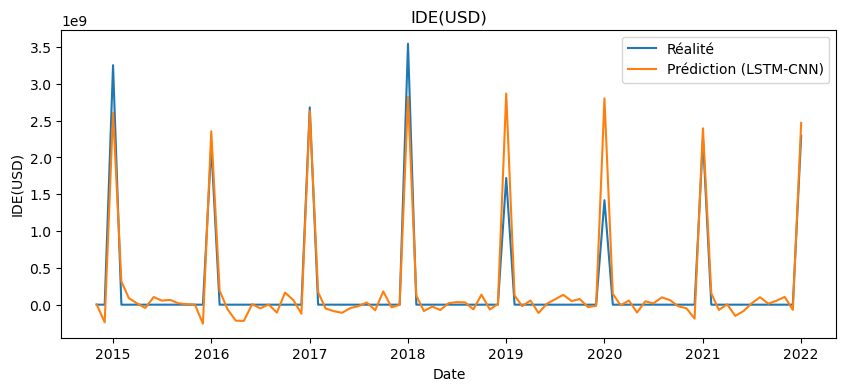

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


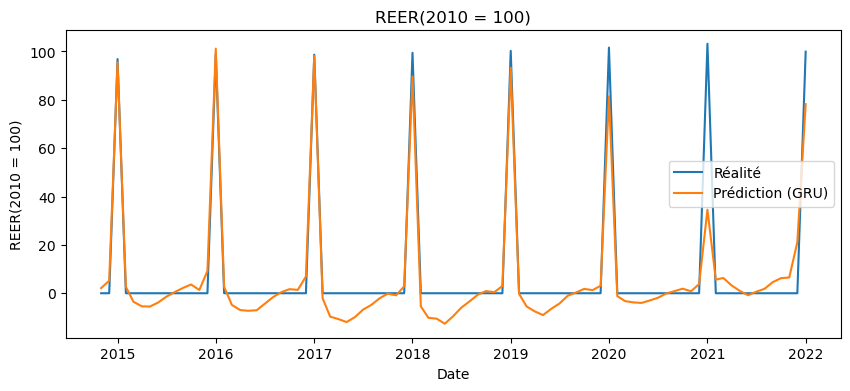

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


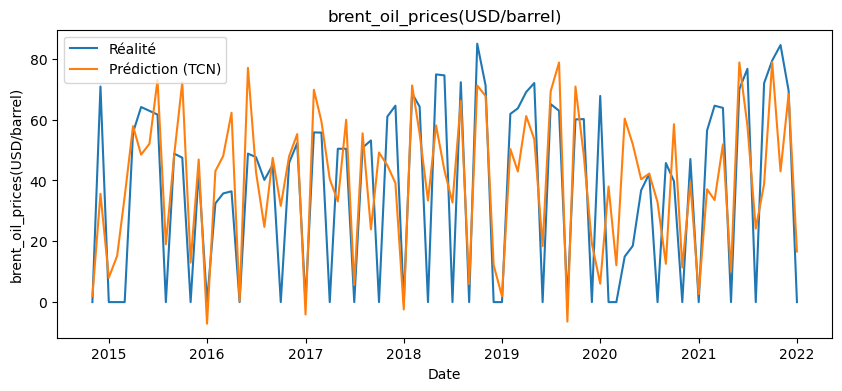

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


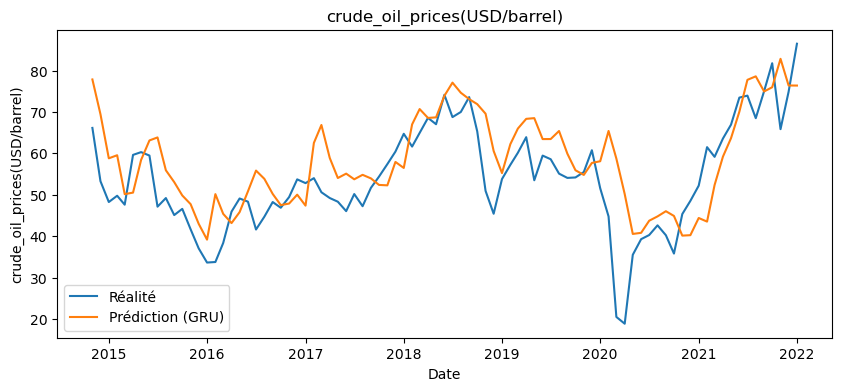

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


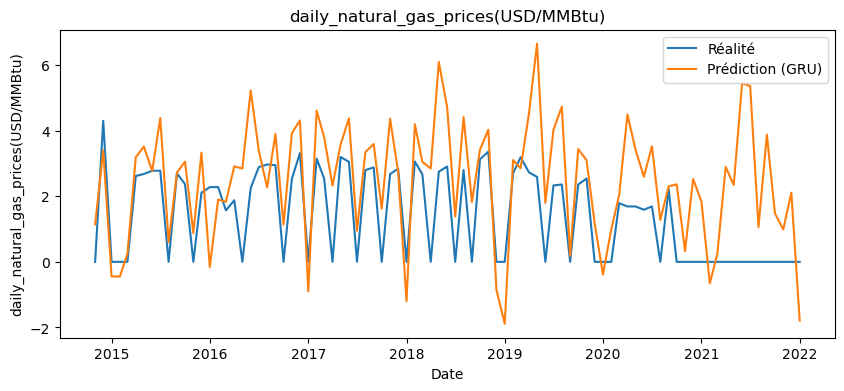

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


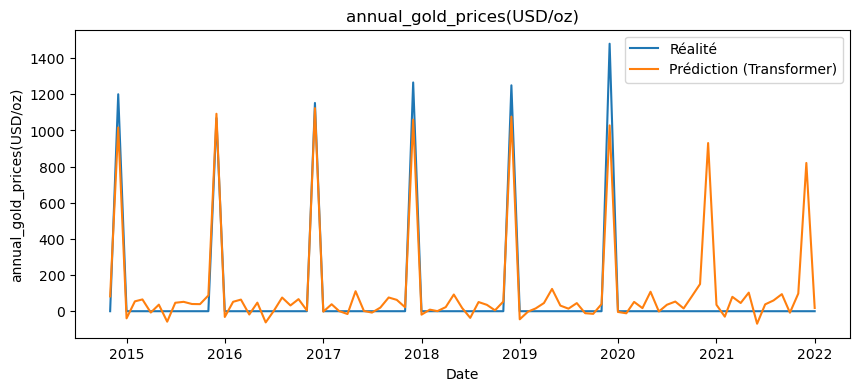

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


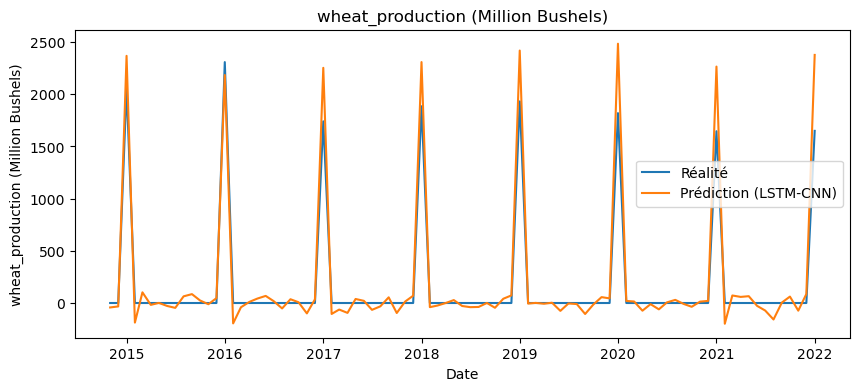

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


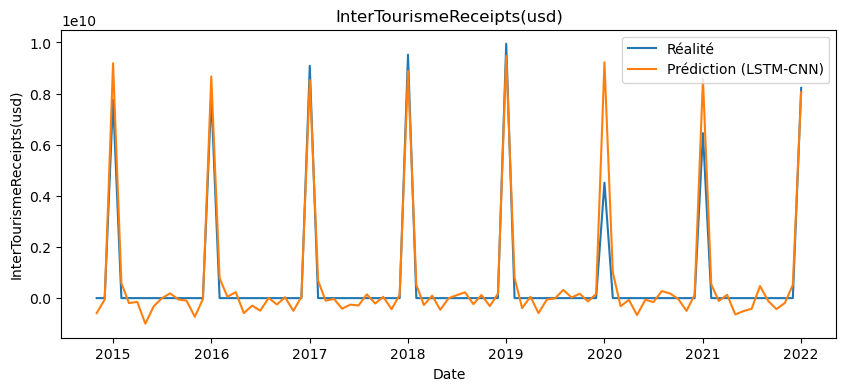

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


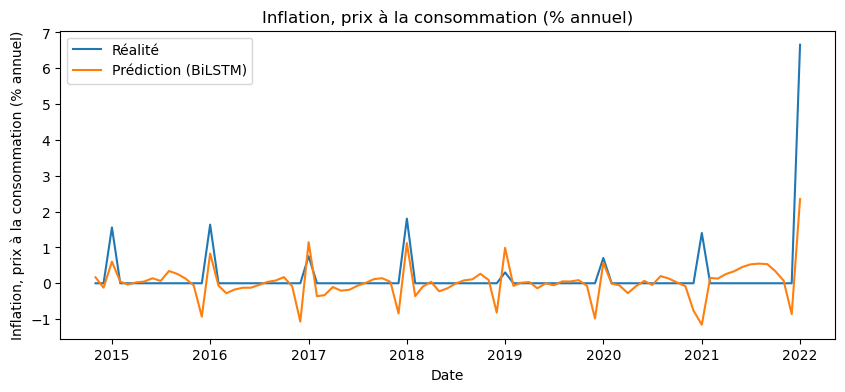

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


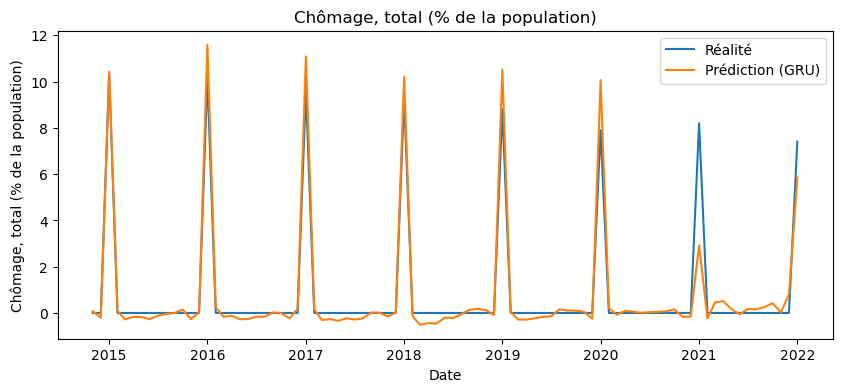

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


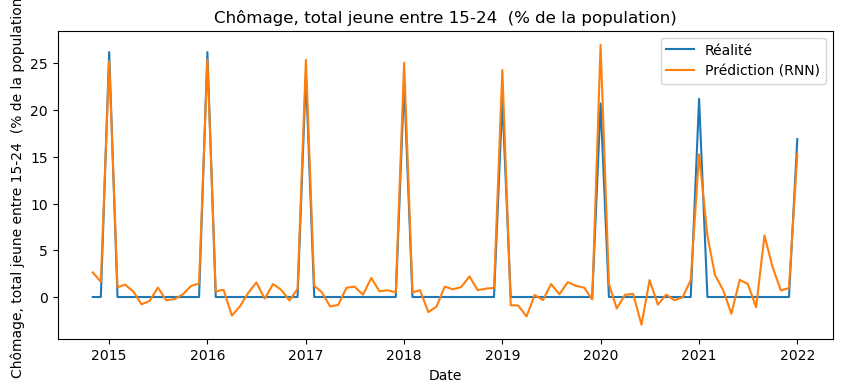

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


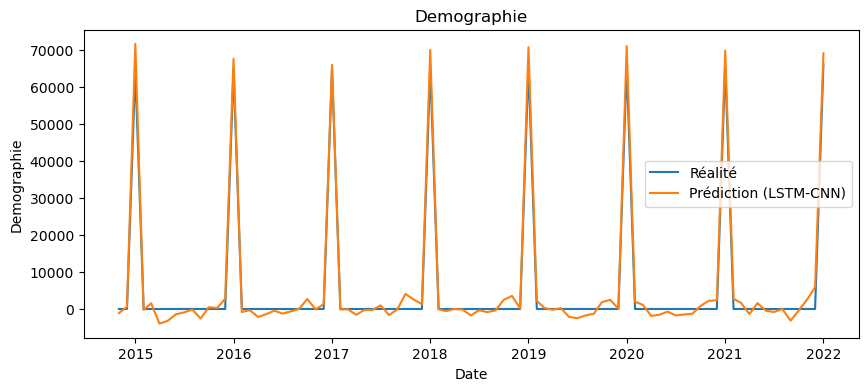

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


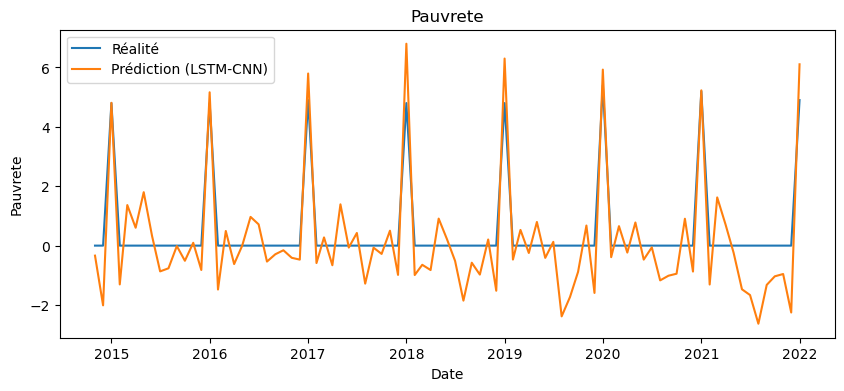

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


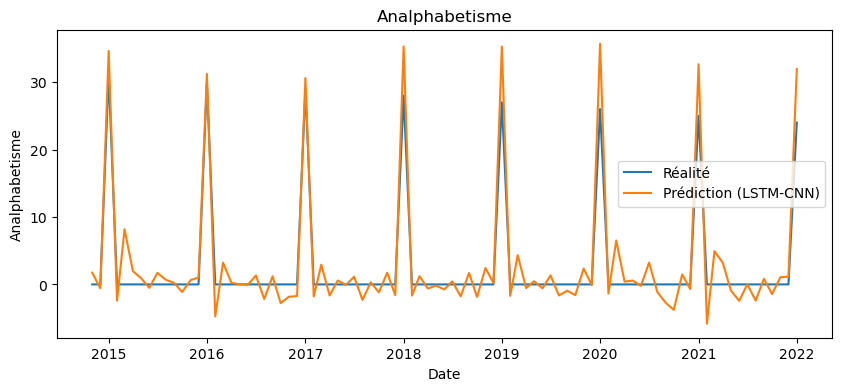

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


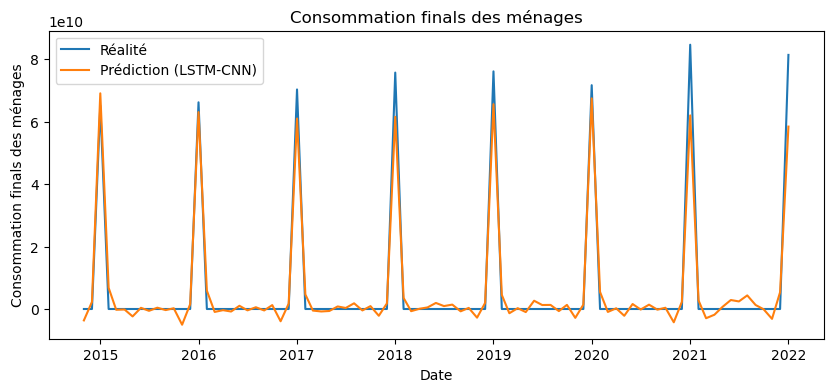

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


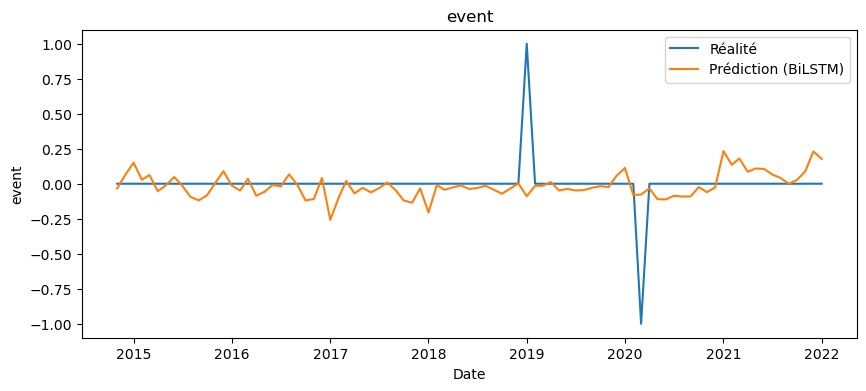

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


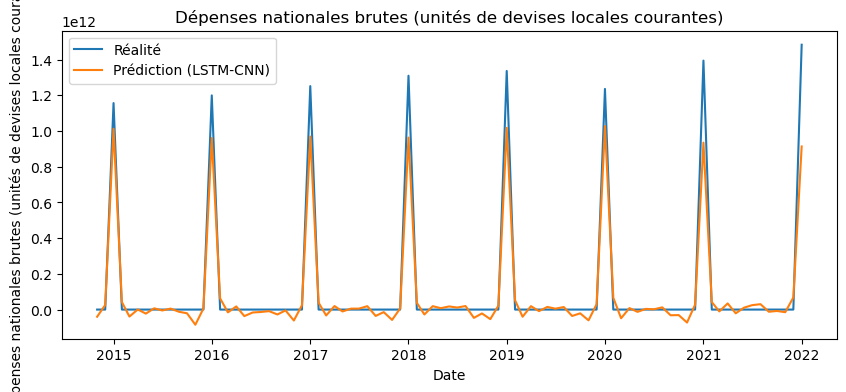

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


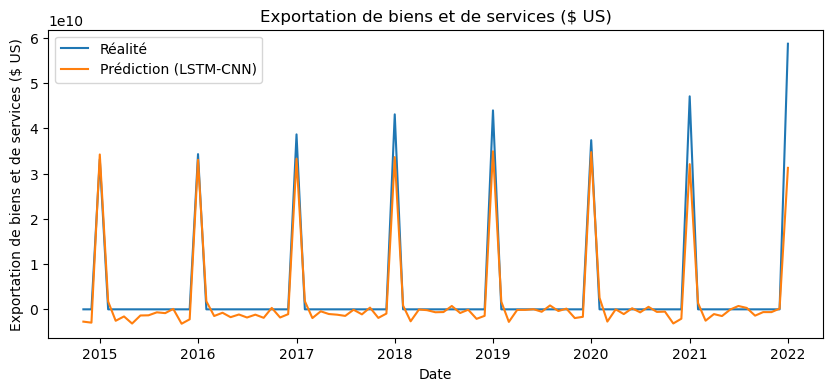

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


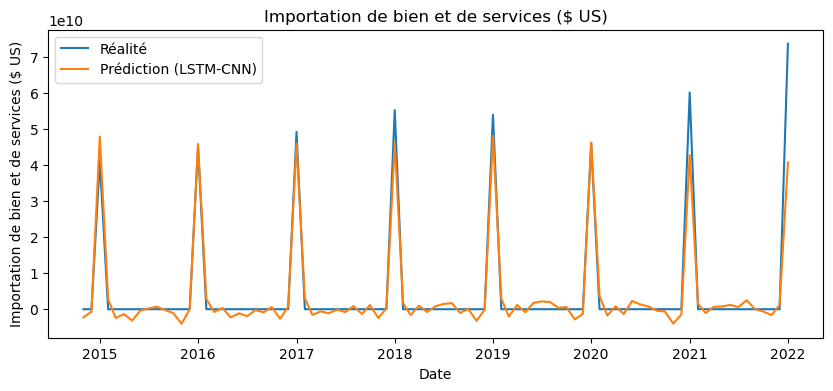

In [19]:
# Cell 13: Visualisation des prédictions pour chaque indicateur

# Utiliser tout l’index de test_df, pas à partir de 30
dates = test_df.index

# y_true calculé en Cell 12 (shape == len(dates) x n_features)
# On le reconstruit au besoin :
target_dims = len(num_cols)
mins   = scaler.min_[:target_dims]
scales = scaler.scale_[:target_dims]
y_true = (y_test - mins) / scales

for i, col in enumerate(num_cols):
    # prédictions du meilleur modèle pour cette colonne
    m = final_models[best_model_per_col[col]]
    preds_scaled = m.predict(X_test)[:, i]
    preds = (preds_scaled - mins[i]) / scales[i]

    plt.figure(figsize=(10, 4))
    plt.plot(dates, y_true[:, i], label='Réalité')
    plt.plot(dates, preds,     label=f'Prédiction ({best_model_per_col[col]})')
    plt.title(col)
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend()
    plt.show()
